## 전이학습(Transfer Learning)
- 합성곱 신경망 기반의 딥러닝 모델을 훈련시키려면 많은 양의 데이터 필요
- 충분히 큰 데이터셋을 확보하려면 많은 돈과 시간이 필요함
- 이러한 어려움을 극복한 것이 **전이 학습(Transfer Learning)**
- 전이 학습이란 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 해결하려는 과제에 맞게 보정해서 사용
- 이미 훈련되어 있는 모델을 사전 훈련된 모델이라고 함

## 특성 추출 기법
- 특성 추출(feature extractor)은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듦
- 학습할 때는 마지막 완전연결층만 학습하고 나머지 계층들은 학습되지 않도록 함
- 특성 추출은 이미지 분류를 위해 두 부분으로 구성
  - 합성곱층: 합성곱층과 풀링층으로 구성
  - 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
- 사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킴

In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Transforms 정의

# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 데이터 취득용 함수 dataset

import torchvision.datasets as datasets

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

batch_size = 128

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True)

test_loader = DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [5]:
# 라이브러리 임포트
from torchvision import models

# 사전 학습 모델 불러오기
net = models.resnet18(weights = 'IMAGENET1K_V1')

# 모델 개요 표시
print(net)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
!pip install torchinfo | tail -n 1

from torchinfo import summary
net = net.to(device)
summary(net,(128, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 1000]               --
├─Conv2d: 1-1                            [128, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 56, 56]         128
├─ReLU: 1-3                              [128, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [128, 64, 28, 28]         --
├─Sequential: 1-5                        [128, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [128, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [128, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [128, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [128, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [128, 64, 28, 28]         --
│

In [7]:
n_output = 10

# 최종 레이어 함수의 입력 차원수 확인
fc_in_features = net.fc.in_features

# 최종 레이어 함수 교체
net.fc = nn.Linear(fc_in_features, n_output)

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
torch.cuda.manual_seed(123)
# 사전 학습 모델 불러오기
model = models.resnet18(weights = 'IMAGENET1K_V1')
# 최종 레이어 함수 입력 차원수 확인
fc_in_features = model.fc.in_features
# 최종 레이어 함수 교체
model.fc = nn.Linear(fc_in_features, n_output)
# GPU 사용
model = model.to(device)
# 학습률
lr = 0.001
# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# 최적화 함수 정의
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# history 파일 초기화
history = np.zeros((0, 5))

In [9]:
# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm

num_epochs = 30

for epochs in range(num_epochs):
  train_acc, train_loss = 0, 0
  test_acc, test_loss = 0, 0
  n_train, n_test = 0, 0

  # 훈련 페이즈
  for inputs, labels in tqdm(train_loader):
    n_train += len(labels)

    # GPU 설정
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # Gradient 초기화

    outputs = model(inputs) # 순전파 계산

    loss = criterion(outputs, labels) # 손실값 계산

    loss.backward() # 역전파 계산

    optimizer.step() # 변수 업데이트

    predicted = outputs.max(axis=1)[1] # 실제 예측은 output중에서 가장 높은 값이 있는 위치

    train_loss += loss.item()
    train_acc += (predicted == labels).sum().item() # 예측과 실제값이 같은 것의 개수

  # 예측 페이즈
  for inputs_test, labels_test in test_loader:
    n_test += len(labels_test)

    # GPU 설정
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = model(inputs_test) # 순전파 계산

    loss_test = criterion(outputs_test, labels_test) # 손실값 계산

    predicted_test = outputs_test.max(axis=1)[1]

    test_loss += loss_test.item()
    test_acc += (predicted_test == labels_test).sum().item() # 손실 및 정확도 저장

  # 평가 결과 산출, 기록
  train_acc = train_acc / n_train # Train 정확도
  train_loss = train_loss / n_train # Train loss
  test_acc = test_acc / n_test # Test 정확도
  test_loss = test_loss / n_test # Test loss

  item = np.array([epochs + 1, train_loss, train_acc, test_loss, test_acc])
  history = np.vstack((history, item)) # Epoch 마다 손실 정확도 저장

  # Epoch 마다 손실과 정확도 표기
  print(f'Epoch [{epochs+1}/{num_epochs}, loss: {train_loss:.5f} acc: {train_acc:.2f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.2f}]')

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/30, loss: 0.00500 acc: 0.78 test_loss: 0.00331, test_acc: 0.86]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/30, loss: 0.00336 acc: 0.85 test_loss: 0.00292, test_acc: 0.88]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/30, loss: 0.00271 acc: 0.88 test_loss: 0.00262, test_acc: 0.89]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/30, loss: 0.00239 acc: 0.90 test_loss: 0.00230, test_acc: 0.90]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/30, loss: 0.00212 acc: 0.91 test_loss: 0.00253, test_acc: 0.89]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/30, loss: 0.00185 acc: 0.92 test_loss: 0.00231, test_acc: 0.90]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/30, loss: 0.00172 acc: 0.92 test_loss: 0.00227, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/30, loss: 0.00157 acc: 0.93 test_loss: 0.00225, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/30, loss: 0.00146 acc: 0.94 test_loss: 0.00229, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/30, loss: 0.00137 acc: 0.94 test_loss: 0.00212, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/30, loss: 0.00127 acc: 0.94 test_loss: 0.00232, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/30, loss: 0.00114 acc: 0.95 test_loss: 0.00230, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/30, loss: 0.00112 acc: 0.95 test_loss: 0.00246, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/30, loss: 0.00104 acc: 0.95 test_loss: 0.00224, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/30, loss: 0.00100 acc: 0.96 test_loss: 0.00235, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/30, loss: 0.00093 acc: 0.96 test_loss: 0.00241, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/30, loss: 0.00092 acc: 0.96 test_loss: 0.00247, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/30, loss: 0.00090 acc: 0.96 test_loss: 0.00241, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/30, loss: 0.00084 acc: 0.96 test_loss: 0.00255, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/30, loss: 0.00084 acc: 0.96 test_loss: 0.00243, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21/30, loss: 0.00076 acc: 0.97 test_loss: 0.00235, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22/30, loss: 0.00071 acc: 0.97 test_loss: 0.00251, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23/30, loss: 0.00072 acc: 0.97 test_loss: 0.00248, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24/30, loss: 0.00068 acc: 0.97 test_loss: 0.00251, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25/30, loss: 0.00070 acc: 0.97 test_loss: 0.00250, test_acc: 0.92]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [26/30, loss: 0.00069 acc: 0.97 test_loss: 0.00236, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [27/30, loss: 0.00063 acc: 0.97 test_loss: 0.00253, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [28/30, loss: 0.00063 acc: 0.97 test_loss: 0.00254, test_acc: 0.91]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [29/30, loss: 0.00064 acc: 0.97 test_loss: 0.00246, test_acc: 0.92]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [30/30, loss: 0.00061 acc: 0.97 test_loss: 0.00252, test_acc: 0.91]


In [ ]:
# 학습 곡선 출력(손실)

plt.plot(history[:, 0], history[:, 1], 'b', label='Train error')
plt.plot(history[:, 0], history[:, 3], 'k', label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 학습 곡선 출력 (정확도)

plt.plot(history[:, 0], history[:, 2], 'b', label='Train accuracy')
plt.plot(history[:, 0], history[:, 4], 'k', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 순환 신경망(RNN)
- RNN(Recurrent Neural Network)은 시간적으로 연속성이 있는 데이터를 처리하려고 고안된 인공 신경망
- RNN의 'Recurrent(반복되는)'는 이전 은닉층이 현재 은닉층의 입력이 되면서 '반복되는 순환 구조를 갖는다'는 의미
- RNN이 기존 네트워크와 다른 점은 '기억'을 갖는다는 것
- 이때 기억은 현재까지 입력 데이터를 요약한 정보
- 새로운 입력이 네트워크로 들어올 때마다 기억은 조금씩 수정되며, 결국 최종적으로 남겨진 기억은 모든 입력 전체를 요약한 정보가 됨

### RNN 구조
- RNN은 은닉층 노드들이 연결되어 이전 단계 정보를 은닉층 노드에 저장할 수 있도록 구성한 신경망
- 다음 그림에서 볼 수 있듯이 xt-1에서 ht-1을 얻고 다음 단계에서 ht-1과 xt를 사용하여 과거 정보와 현재 정보를 모두 반영
- 또한, ht와 xt+1의 정보를 이용하여 과거와 현재 정보를 반복해서 반영하는데, 이러한 구조를 요약한 것이 다음 그림의 오른쪽 부분과 같음

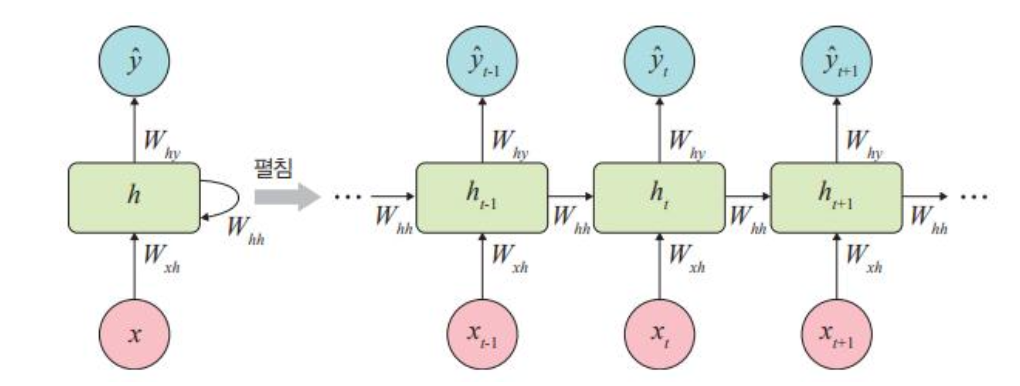